In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
pip install blitz-bayesian-pytorch

In [ ]:
pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import blitz
from blitz.modules import BayesianLSTM
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import yfinance as yf

#### Pick Device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
#using data from Yahoo, with date starting from January 2018
def Stockloader(stock_symbol): 
    orig_data=yf.Ticker(stock_symbol).history(period='3Y')
    
    orig_data['TypPrice']=  (orig_data['High'] + orig_data['Low'] + orig_data['Close'] ) /3

            
    pre_data=orig_data.drop(['Dividends','Stock Splits'],axis=1) #'Date'
    
    labels=pre_data.columns
    scaler=MinMaxScaler(feature_range=(-1,1))
    scaled_data=scaler.fit_transform(pre_data)
    data=pd.DataFrame(scaled_data,columns=labels)

    return data, scaler

####Insert stock_symbol here

In [ ]:
#stock symbol is an all caps string
stock_symbol= 'NVDA'
data, scaler=Stockloader(stock_symbol)
typ_ind=data.columns.get_loc('TypPrice')
high_ind= data.columns.get_loc('High')
low_ind=data.columns.get_loc('Low')
data.head()

,Open,High,Low,Close,Volume,TypPrice
0,-0.747994,-0.765041,-0.757775,-0.764950,-0.645286,-0.760870
1,-0.766657,-0.777146,-0.755166,-0.751548,-0.753425,-0.759689
2,-0.742624,-0.768282,-0.753313,-0.752228,-0.713756,-0.756261
3,-0.751754,-0.763519,-0.736972,-0.738145,-0.744122,-0.744522
4,-0.731615,-0.741029,-0.717885,-0.733247,-0.620484,-0.728856


#### Hyperparameters

In [ ]:
sample_len=4
hidden_size=120
#num_layers=1
batch_size=1
learning_rate=0.001
num_epochs= 1000 #100
dropout=0.2
#weight_decay=0.0001

In [ ]:
def Extract_XY(data,train_ratio):
    chunk_list=[]

    num_targets=len(data)-sample_len

    for timestep in range(num_targets):
        end_index=timestep+sample_len+1 #targets are only '1' index ahead of inputs
        chunk_list.append(data.iloc[timestep:end_index,:].values)

    chunks=np.array(chunk_list)

    train_data=chunks[:round(train_ratio*data.shape[0])]
    test_data=chunks[round(train_ratio*data.shape[0]):]

    train_inputs=train_data[:,:-1,:]
    train_targets=train_data[:][:,1:,:]

    test_inputs=test_data[:][:,:-1,:]
    test_targets=test_data[:][:,1:,:]

    return train_inputs,train_targets, test_inputs, test_targets


In [ ]:
def Tensify(data,train_ratio):
    tensor_list=[]
    train_inputs, train_targets, test_inputs, test_targets = Extract_XY(data,train_ratio)
    
    data_list=[train_inputs,train_targets,test_inputs,test_targets]
    
    for data in data_list:
        tensor_list.append(torch.Tensor(data)) 
        
    train_inputs=tensor_list[0]
    train_targets=tensor_list[1]
    test_inputs=tensor_list[2]
    test_targets=tensor_list[3]
    
    return train_inputs,train_targets,test_inputs,test_targets

In [ ]:
train_inputs, train_targets, test_inputs, test_targets= Tensify(data,0.8)

#input dimensions= (num_samples,sample_len, num_features), output dimensions= (num_samples,num_features)
print(train_inputs.shape,train_targets.shape,test_inputs.shape,test_targets.shape)

torch.Size([603, 4, 6]) torch.Size([603, 4, 6]) torch.Size([147, 4, 6]) torch.Size([147, 4, 6])


In [ ]:
@variational_estimator
class net(nn.Module):
    def __init__(self,hidden_size,dropout,batch_first=True):#batch_first=True
        super(net,self).__init__()
        self.hidden_size=hidden_size
      
        self.input_size=train_inputs.shape[2] #number of features
        self.output_size= self.input_size #should = input_size, but change to 1 if we're interested in only 1 feature
        
        self.dropout=nn.Dropout(dropout)
        self.lstm=BayesianLSTM(self.input_size,self.hidden_size)
        #self.linear=BayesianLinear(self.hidden_size,self.output_size)
        self.linear=nn.Linear(self.hidden_size,self.output_size)

    def forward(self, inputs):
        output, (hidden,cell) =self.lstm(inputs)
        output=self.dropout(output)
        output= self.linear(output) 
        return output

model=net(hidden_size,dropout)
model.to(device)

net(
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): BayesianLSTM(
    (weight_ih_sampler): TrainableRandomDistribution()
    (weight_hh_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_ih_prior_dist): PriorWeightDistribution()
    (weight_hh_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (linear): Linear(in_features=120, out_features=6, bias=True)
)

#### Training and Evaluation Steps

In [ ]:
##pick optimizer and loss function
loss_func = nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters(), lr=learning_rate)#weight_decay=weight_decay)

In [ ]:
def train_step(inputs, targets):
    
    model.zero_grad()
    
    loss = model.sample_elbo(inputs,targets,loss_func,sample_nbr=3,complexity_cost_weight=1/inputs.shape[0])
    
    loss.backward()#(retain_graph=True)
    optimizer.step()
    
    avg_loss=loss/sample_len
    
    return avg_loss

In [ ]:
def eval_step(inputs,targets):
    
    model.eval()

    
    #for test_inputs, test_targets in test_loader:
        #test_inputs,test_targets=test_inputs.to(device), test_targets.to(device)
    
     
    evals,_= model.mfvi_forward(inputs,sample_nbr=10)
    
    loss=loss_func(evals,targets)
    
    avg_loss=loss/sample_len/len(targets)
    
    
    return evals, avg_loss

In [ ]:
train_inputs,train_targets,test_inputs,test_targets=train_inputs.to(device),train_targets.to(device),test_inputs.to(device),test_targets.to(device)
train_losses=[]
loss_sum=0
for epoch in range(num_epochs):
    #for train_inputs, train_targets in train_loader:
    #for train_inputs, train_targets in training_loader:
    #train_inputs,train_targets=train_inputs.to(device),train_targets.to(device)
    avg_loss=train_step(train_inputs,train_targets)
    loss_sum+=avg_loss
    if (epoch % 5) == 4: 
        train_losses.append(loss_sum/5)
        loss_sum=0

evals, eval_loss=eval_step(test_inputs,test_targets)


Text(0.5, 1.0, 'Training Loss Over Epochs')

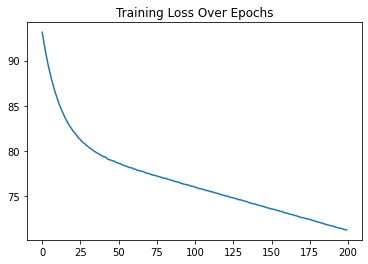

In [ ]:
plt.plot(train_losses)
plt.title('Training Loss Over Epochs')

plt.title('Train Predictions vs Actual ')
plt.plot(output[:,-1,high_ind].cpu().detach().numpy(), label="Predicted")
plt.plot(train_targets[:,-1,high_ind].cpu().detach().numpy(),label='Actual')
plt.ylabel('typical_price')
plt.xlabel('timestep')
plt.legend()
plt.show()

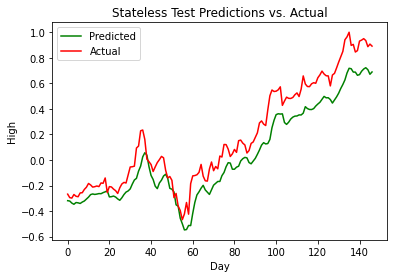

In [ ]:
plt.title('Stateless Test Predictions vs. Actual')
#plt.plot(restored_evals[:,high_ind], 'g',label='Predicted')
#plt.plot(restored_test_targets[:,high_ind],'r',label='Actual')
plt.plot(evals[:,-1,high_ind].cpu().detach().numpy(), 'g',label='Predicted')
plt.plot(test_targets[:,-1,high_ind].cpu().detach().numpy(),'r',label='Actual')
plt.ylabel('High')
plt.xlabel('Day')
plt.legend()
plt.show()

In [ ]:
def StockPredictor(train_inputs,data,stock_symbol): 
    
    retrain=torch.Tensor(data[-sample_len:].values).to(device)
        
    pred=model(retrain.view(-1,retrain.shape[0],retrain.shape[1]))
    rescaled_pred=scaler.inverse_transform(pred.view(pred.shape[1],pred.shape[2]).cpu().detach())
    
    high=rescaled_pred[-2:,high_ind]
    low=rescaled_pred[-2:,low_ind]

    print('Avg Error is',eval_loss)
    
    for day in range(len(high)):
        if day<high.shape[0]-1:
            
            if high[day] > high[day+1]:
                print('Sell for day',day,'at',high[day])
            elif high[day] == high[day+1]:
                print('Hold for day',day)
            elif high[day] < high[day+1]:
                print('Hold/buy for day',day,'at',low[day])        
            else:
                break
    
    
    plt.title('Stock Forecast for'+ ' '+ stock_symbol)
    plt.plot(high)
    plt.ylabel(data.columns[high_ind])
    plt.xlabel('Day')

Avg Error is tensor(0.0001, grad_fn=<DivBackward0>)
Hold/buy for day 0 at 362.93690524101254


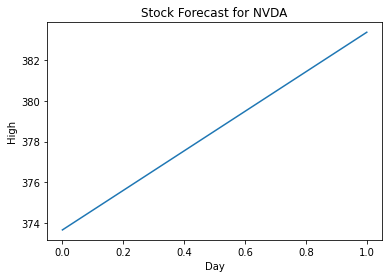

In [ ]:
StockPredictor(train_inputs,data,stock_symbol)